# Example analysis

You should have installed CAVEclient before starting this script.

Running this script under anaconda virtual environment is highly recommended.


This notebook shows how to:
1) Load dataset
2) Pick a desired neuron
3) Plot a neuron's synapse and skeleton
4) Have a look at functional profile of a neuron
5) Simple analysis of excitatory neuron's functional properties

# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import sys
import os

# Import dendrite libraries: Set path for script_analysis
sys.path.append(os.path.abspath('./script_analysis'))
import dendrites as dd
import skeleton_plots as skp
import synapse_analysis as synapse_anal

# 1. Load dataset

You have to mount NAS on your PC first

This step is where you load synapse and skeleton data of a neuron.
Once they are loaded, you don't have to load them again. 
Come back to this section if you want to try different neurons.

## 1.1. Read data from NAS

In [4]:
# Read tables from NAS
from pathlib import Path
import pandas as pd

# Your path to NAS
NAS = Path("/media/DATA1/CK/FANCiNAS1/Lab_Share/Chaewon/microns")
ANN = NAS / "ann_tables"
SYP = NAS / "synapse"
SK = NAS / "skeleton/skeleton_raw"

# Read annotation tables
dend_extended_df = pd.read_pickle(ANN / "dend_extended_df")
coregistration_manual_v4 = pd.read_pickle(ANN / "coregistration_manual_v4")
nucleus_detection_v0 = pd.read_pickle(ANN / "nucleus_detection_v0")
aibs_metamodel_celltypes_v661 = pd.read_pickle(ANN / "aibs_metamodel_celltypes_v661")
nucleus_functional_area_assignment = pd.read_pickle(ANN / "nucleus_functional_area_assignment")
functional_properties_v3_bcm = pd.read_pickle(ANN / "functional_properties_v3_bcm")

In [14]:
# Query synapses (sample neuron)
neuron_id = 864691135430194992
pre_synapse_df = pd.read_pickle(SYP / f"{neuron_id}_pre_synapse_df.pkl")

# Check loaded data
pre_synapse_df.head()

id                          created  superceded_id valid   size  \
0  194631708 2020-11-04 06:48:59.787324+00:00            NaN     t   2512   
1  167742624 2020-11-04 14:41:17.519298+00:00            NaN     t   3588   
2  167649356 2020-11-04 06:49:11.546047+00:00            NaN     t   7640   
3  160289190 2020-11-04 06:48:59.403833+00:00            NaN     t    588   
4  208130837 2020-11-04 06:48:59.036865+00:00            NaN     t  19660   

   pre_pt_supervoxel_id      pre_pt_root_id  post_pt_supervoxel_id  \
0     92120933875231176  864691135986474632      92120933875247093   
1     89659745547505704  864691135954917640      89659745547522038   
2     89730114224935729  864691135239538047      89800482969128296   
3     89376690157460072  864691135401242354      89376758876927521   
4     92965358939658598  864691136117590436      92965358939661746   

      post_pt_root_id          pre_pt_position         post_pt_position  \
0  864691135430194992  [198746, 122116, 25718]  [198700, 122196, 25724]   
1  864691135430194992  [181212, 134970, 23674]  [181222, 135026, 23681]   
2  864691135430194992  [181738, 135308, 23459]  [181812, 135334, 23472]   
3  864691135430194992  [178830, 123516, 25083]  [178888, 123612, 25069]   
4  864691135430194992  [204838, 122224, 26809]  [204842, 122110, 26811]   

           ctr_pt_position  
0  [198740, 122172, 25724]  
1  [181210, 135019, 23675]  
2  [181767, 135332, 23470]  
3  [178812, 123556, 25074]  
4  [204832, 122156, 26803]

In [15]:
# Query skeleton (sample neuron)
neuron_id = 864691135430194992
sk_swc = pd.read_csv(SK / f"{neuron_id}_sk_swc_raw.csv")

# Check loaded data
sk_swc.head()

Unnamed: 0  id  type        x        y        z  radius  parent
0           0   0     1  757.888  477.184  1041.48   6.559      -1
1           1   1     2  762.768  483.072  1045.00   0.296       0
2           2   2     2  763.032  485.040  1045.52   0.296       1
3           3   3     2  763.056  487.184  1045.88   0.296       2
4           4   4     2  763.376  489.216  1046.88   0.296       3

## 1.2. Read data from CAVEclient

You must have installed caveclient before you proceed

In [25]:
# CAVE Client setup
from caveclient import CAVEclient

# Set dataset version
datastack_name = "minnie65_public"
client = CAVEclient(datastack_name)
client.materialize.version= 1300

In [26]:
# Query annotation tables

# Get list of neurons with extended proofreading of dendrites
dend_extended_df = client.materialize.query_table('proofreading_status_and_strategy',filter_in_dict={"strategy_dendrite": ["dendrite_extended"]})

# Coregistration table:   Between EM and 2P functional image
coregistration_manual_v4 = client.materialize.query_table('coregistration_manual_v4')

# nucleus_detection_v0: Table of each nucleus and their ID
nucleus_detection_v0= client.materialize.query_table('nucleus_detection_v0')

# aibs_metamodel_celltypes_v661:    Cell type and layer
aibs_metamodel_celltypes_v661= client.materialize.query_table('aibs_metamodel_celltypes_v661')

# neucleus_functional_area_assignment:      area [V1, LM, AL, RL]
nucleus_functional_area_assignment= client.materialize.query_table('nucleus_functional_area_assignment')

# functional_properties_v3_bcm
functional_properties_v3_bcm = client.materialize.tables.functional_properties_v3_bcm().query()

In [27]:
# === Query synapses (sample neuron) ===
neuron_id = 864691135430194992
pre_synapse_df = client.materialize.synapse_query(post_ids = neuron_id)
post_synapse_df = client.materialize.synapse_query(pre_ids = neuron_id)

# Check loaded data
pre_synapse_df.head()

/home/ckang/anaconda3/envs/micronsbinder_02/lib/python3.9/site-packages/caveclient/materializationengine.py:1745: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  return df.query("pre_pt_root_id!=post_pt_root_id")
/home/ckang/anaconda3/envs/micronsbinder_02/lib/python3.9/site-packages/caveclient/materializationengine.py:1745: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  return df.query("pre_pt_root_id!=post_pt_root_id")


id                          created  superceded_id  valid     size  \
0  194631708 2020-11-04 06:48:59.787324+00:00           <NA>   True   2512.0   
1  167742624 2020-11-04 14:41:17.519298+00:00           <NA>   True   3588.0   
2  167649356 2020-11-04 06:49:11.546047+00:00           <NA>   True   7640.0   
3  160289190 2020-11-04 06:48:59.403833+00:00           <NA>   True    588.0   
4  208130837 2020-11-04 06:48:59.036865+00:00           <NA>   True  19660.0   

   pre_pt_supervoxel_id      pre_pt_root_id  post_pt_supervoxel_id  \
0     92120933875231176  864691135986474632      92120933875247093   
1     89659745547505704  864691135954917640      89659745547522038   
2     89730114224935729  864691135239538047      89800482969128296   
3     89376690157460072  864691135401242354      89376758876927521   
4     92965358939658598  864691136117590436      92965358939661746   

      post_pt_root_id          pre_pt_position         post_pt_position  \
0  864691135430194992  [198746, 122116, 25718]  [198700, 122196, 25724]   
1  864691135430194992  [181212, 134970, 23674]  [181222, 135026, 23681]   
2  864691135430194992  [181738, 135308, 23459]  [181812, 135334, 23472]   
3  864691135430194992  [178830, 123516, 25083]  [178888, 123612, 25069]   
4  864691135430194992  [204838, 122224, 26809]  [204842, 122110, 26811]   

           ctr_pt_position  
0  [198740, 122172, 25724]  
1  [181210, 135019, 23675]  
2  [181767, 135332, 23470]  
3  [178812, 123556, 25074]  
4  [204832, 122156, 26803]

Skeleton swc data format:

* `id` : the node index
* `radius` : cable radius (um)
* `type` : 1: soma; 2: axon; 3: (basal) dendrite. Sometimes 4: apical dendrite (depending on skeleton version)
* `x`,`y`,`z` : node position in the volume (um)

In [48]:
# ===== Query skeletons (sample neuron) =====
neuron_id = 864691135430194992
sk_swc = client.skeleton.get_skeleton(neuron_id, output_format='swc', skeleton_version=2)

# Check loaded data
sk_swc.head()

id  type        x        y        z  radius  parent
0   0     1  757.888  477.184  1041.48   6.559      -1
1   1     2  762.768  483.072  1045.00   0.296       0
2   2     2  763.032  485.040  1045.52   0.296       1
3   3     2  763.056  487.184  1045.88   0.296       2
4   4     2  763.376  489.216  1046.88   0.296       3

# 2. Plot

## 2.1. Select neuron

Here you can filter types of neuron you want to analyze. \
**NOTE:**  <ins>Some neurons are incorrectly labled. It's recommended to check them on Neuroglancer before you proceed.<ins>

In [121]:
select_layer = "MC"  # 23P, 4P, 5P, etc
select_area = "V1"    # V1, LM, AL, RL
proof_status = False

# 1) start set
list_pt_root_id = coregistration_manual_v4[['pt_root_id']].drop_duplicates()

# 2) filter by layer
mask = aibs_metamodel_celltypes_v661['cell_type'] == select_layer
ids_23 = aibs_metamodel_celltypes_v661.loc[mask, 'pt_root_id'].drop_duplicates()
list_pt_root_id = list_pt_root_id[list_pt_root_id['pt_root_id'].isin(ids_23)]

# 3) filter by area
mask = nucleus_functional_area_assignment['tag'] == select_area
ids_v1 = nucleus_functional_area_assignment.loc[mask, 'pt_root_id'].drop_duplicates()
list_pt_root_id = list_pt_root_id[list_pt_root_id['pt_root_id'].isin(ids_v1)]

# 4) filter by dendrite proofreading ("dendrite_extended")
if proof_status == True:
    ids_dend_ext = (dend_extended_df['pt_root_id'].dropna().drop_duplicates())
    list_pt_root_id = list_pt_root_id[list_pt_root_id['pt_root_id'].isin(ids_dend_ext)]

In [17]:
# See the list
list_pt_root_id

pt_root_id
1094   864691135938220292
1121   864691136051346419
1152   864691136926174538
1163   864691135837182611
1516   864691136723477501
1599   864691136673009543
1632   864691136176254470
1670   864691135884675184
2787   864691135538374002
2862                    0
2865   864691135938441269
3858   864691136042178134
3865   864691136272926654
3870   864691135572269605
3947   864691135850643399
4023   864691135532229572
4092   864691135494013892
4731   864691135570388870
6383   864691135383516890
6385   864691135355998671
6432   864691135234076505
6442   864691134989629562
6809   864691136487890450
6820   864691135952515363
8100   864691136033332923
8191   864691135375394889
8350   864691135941162753
10419  864691135501771330
10605  864691136020907768
10636  864691135927179476
10640  864691135163103533
10668  864691135464067741
10678  864691135749122857
11468  864691135395705077
11668  864691135463429950
11725  864691135719250481
11726  864691135940329894
11727  864691135275365349
11735  864691135572666149
11836  864691135489196602
17970  864691136051924211
18196  864691135947452964
18277  864691135350218711
18309  864691136238336316

## 2.2. Plot pre-synapses

Make sure your neuron's data is loaded above. \
In this section we will plot a single neuron's pre synapses.

In [18]:
# Helper Function

# column to a np.array of Nx3 size in nm
def convert_to_nm(col, voxel_size=[4,4,40]):
    return np.vstack(col.values)*voxel_size

# Gets orientation difference between pre-post synapse
def orientation_to_colour(syn_pref_ori, neuron_pref_ori):   
    # Normalize the orientations from [0, π] to [0, 1]
    syn_pref_ori_normalized = syn_pref_ori / np.pi
    neuron_pref_ori_normalized = neuron_pref_ori / np.pi
    
    # Centering on the Post-Synaptic Neuron's preferred orientation
    #oss: %1.0 serve per trasformare valori come 1.1 in 0.1 (scala da 0 a 1) "Wrap around"
    relative_orientation = (syn_pref_ori_normalized - neuron_pref_ori_normalized) % 1.0
    
    colour = cm.hsv(relative_orientation)
  
    # Return RGB and no Alpha(transparency)
    return colour[:3]

In [19]:
# Plot all pre-synapses
def plot_synapses_for_post_neuron(pre_synapse_df, nucleus_detection_v0, pt_root_id):
    """
    Plot all synapses (x–y and x–z views) for a single postsynaptic neuron in nm→µm space.
    """

    # If no pt_root_id given, assume there's only one in this df (like your original code)
    if pt_root_id is None:
        pt_root_id = pre_synapse_df['post_pt_root_id'].unique()[0]

    # Filter synapses for this neuron
    pre_synapse_sub = pre_synapse_df[pre_synapse_df['post_pt_root_id'] == pt_root_id]

    # Get synapse positions in nm
    syn_pos_nm = convert_to_nm(pre_synapse_sub['ctr_pt_position'])

    # Find soma position in nm
    soma_mask = nucleus_detection_v0['pt_root_id'] == pt_root_id
    soma_pos = convert_to_nm(nucleus_detection_v0.loc[soma_mask, 'pt_position'])

    # Convert nm → µm
    syn_pos_um = syn_pos_nm / 1000.0
    soma_pos_um = soma_pos[0] / 1000.0  # (x, y, z)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # x–y view
    ax[0].scatter(syn_pos_um[:, 0], syn_pos_um[:, 1], s=1, color='black', alpha=0.6)
    ax[0].scatter(soma_pos_um[0], soma_pos_um[1], s=20, color='red', label='Soma')

    ax[0].set_aspect('equal')
    ax[0].set_xlabel('x (µm)')
    ax[0].set_ylabel('y (µm)')
    ax[0].set_title('Synapse positions (x–y)')
    ax[0].legend(loc='best')
    ax[0].invert_yaxis()

    # x–z view
    ax[1].scatter(syn_pos_um[:, 0], syn_pos_um[:, 2], s=1, color='black', alpha=0.6)
    ax[1].scatter(soma_pos_um[0], soma_pos_um[2], s=20, color='red')

    ax[1].set_aspect('equal')
    ax[1].set_xlabel('x (µm)')
    ax[1].set_ylabel('z (µm)')
    ax[1].set_title('Synapse positions (x–z)')

    plt.tight_layout()
    plt.show()

    return fig, ax

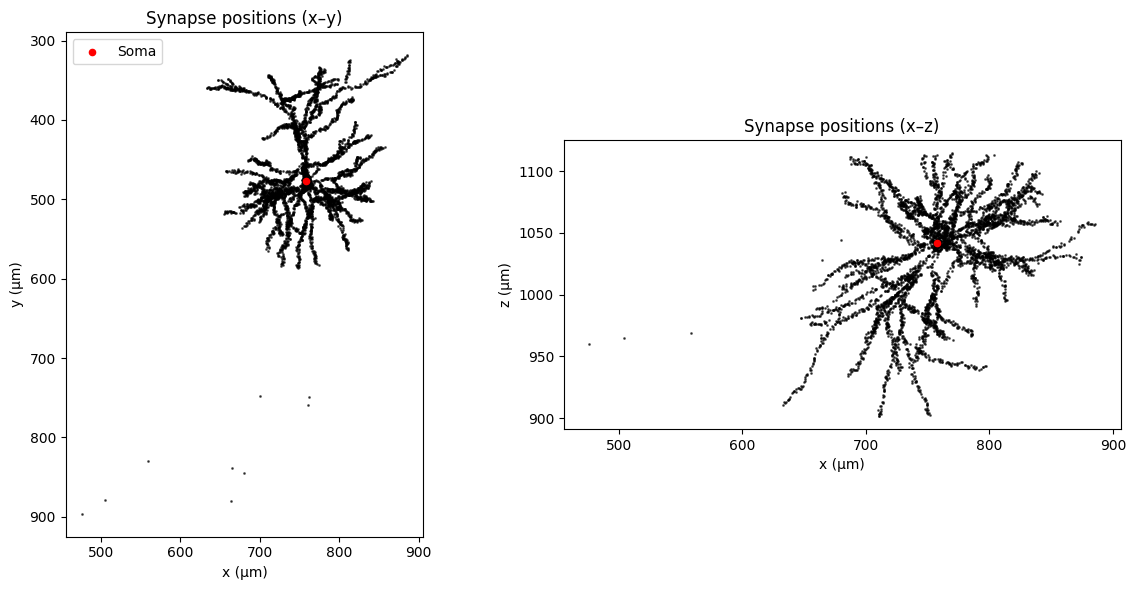

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Synapse positions (x–y)'}, xlabel='x (µm)', ylabel='y (µm)'>,
        <Axes: title={'center': 'Synapse positions (x–z)'}, xlabel='x (µm)', ylabel='z (µm)'>],
       dtype=object))

In [20]:
plot_synapses_for_post_neuron(pre_synapse_df, nucleus_detection_v0, pt_root_id=neuron_id)

In [21]:
def plot_synapses_soma_relative(pre_synapse_df, nucleus_detection_v0, pt_root_id, y_depth):
    """
    Compute synapse positions relative to soma and plot x–y around soma (0,0)
    Adjust y_depth for depth control
    """

    # Work on a copy so original df is untouched
    pre_synapse_df = pre_synapse_df.copy()

    # Bring soma location
    if pt_root_id is None:
        pt_root_id = pre_synapse_df['post_pt_root_id'].unique()[0]

    mask = nucleus_detection_v0['pt_root_id'] == pt_root_id
    soma_pos = convert_to_nm(nucleus_detection_v0.loc[mask, 'pt_position'])
    soma_pos_x = soma_pos[0, 0]
    soma_pos_y = soma_pos[0, 1]
    soma_pos_z = soma_pos[0, 2]

    # Add real-world scaled positions (nm)
    pre_synapse_df['ctr_pt_position_real'] = list(
        convert_to_nm(pre_synapse_df['ctr_pt_position'], voxel_size=[4, 4, 40])
    )

    # Soma-relative positions (still in nm)
    pre_synapse_df['ctr_pt_position_somarel'] = pre_synapse_df['ctr_pt_position_real'].apply(
        lambda pos: [pos[0] - soma_pos_x,
                     pos[1] - soma_pos_y,
                     pos[2] - soma_pos_z]
    )

    # Convert to NumPy array for plotting
    syn_pos_rel = np.array(pre_synapse_df['ctr_pt_position_somarel'].tolist())  # (N, 3)

    # Plot x–y around soma
    plt.figure(figsize=(6, 6))
    plt.scatter(syn_pos_rel[:, 0] / 1000, syn_pos_rel[:, 1] / 1000, s=1, color='k')  # nm → µm
    plt.gca().set_aspect('equal')

    # Soma at the origin
    plt.scatter(0, 0, s=10, color='r')

    plt.title(f"Neuron {pt_root_id}")
    plt.xlabel('x (μm)')
    plt.ylabel('y (μm)')
    plt.xlim(-200, 200)
    plt.ylim(-y_depth, 200)
    plt.gca().invert_yaxis()
    
    # If you want to save:
    # output_dir = "/media/imaging/DATA4/CK/python_script/MicronsBinder_03/results/all_synapses/"
    # output_path = os.path.join(output_dir, f"{pt_root_id}_neuron_synapses.png")
    # plt.savefig(output_path)

    plt.show()

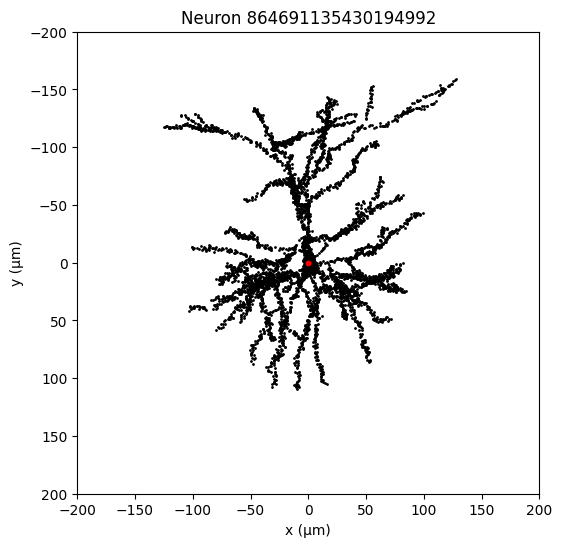

In [22]:
# try changing y_depth from 200 to 600
plot_synapses_soma_relative(pre_synapse_df, nucleus_detection_v0, neuron_id, y_depth = 200)

## 2.3. Skeleton plot

Make sure you loaded skeleton data of a neuron above \
This section we will plot a neuron's skeleton nodes.

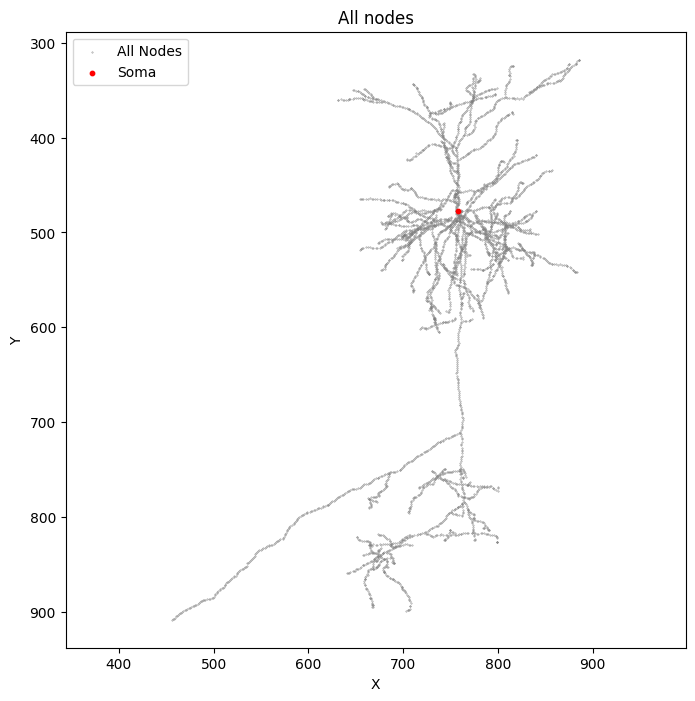

In [23]:
# Raw skeleton plot
skp.plot_skeleton_nodes(sk_swc)

## 2.3. Skeleton cluster plot

Here we will use only dendrites and cluster them in different orders.

In [49]:
# Filter skeleton only to dendrites
mask = (sk_swc["type"] == 1) |(sk_swc["type"] == 3) | (sk_swc["type"] == 4)
sk_swc_dend = sk_swc[mask]

In [50]:
# Dendrite clustering
sk_swc_levels = sk_swc_dend.copy()
sk_swc_levels = dd.assign_branch_order(sk_swc_levels)
sk_swc_levels = dd.assign_dendrites(sk_swc_levels)
sk_swc_levels = dd.assign_segments(sk_swc_levels)
sk_swc_levels = dd.compute_skeleton_tree_distances(sk_swc_levels)

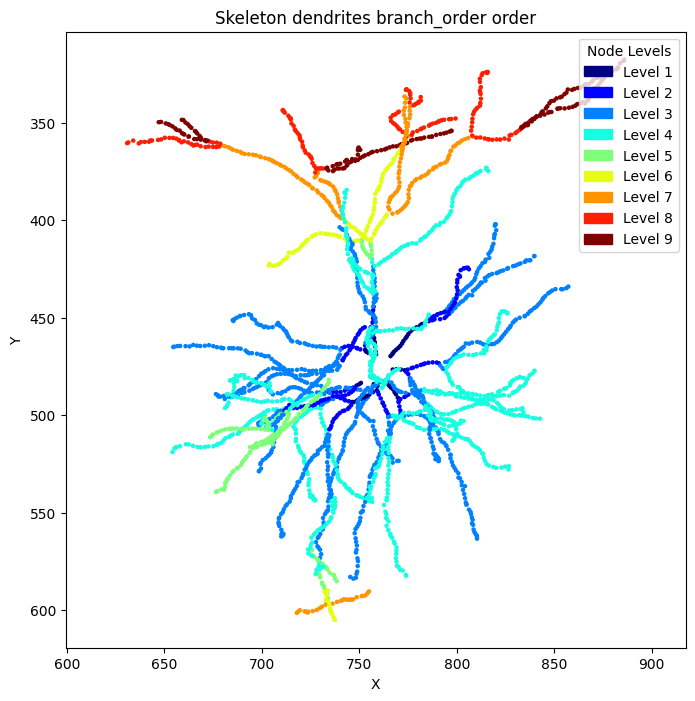

In [51]:
# Visualization
skp.plot_skeleton_by_levels_2d(sk_swc_levels, "branch_order", "max", neuron_id, dir_name="NA", save=False)

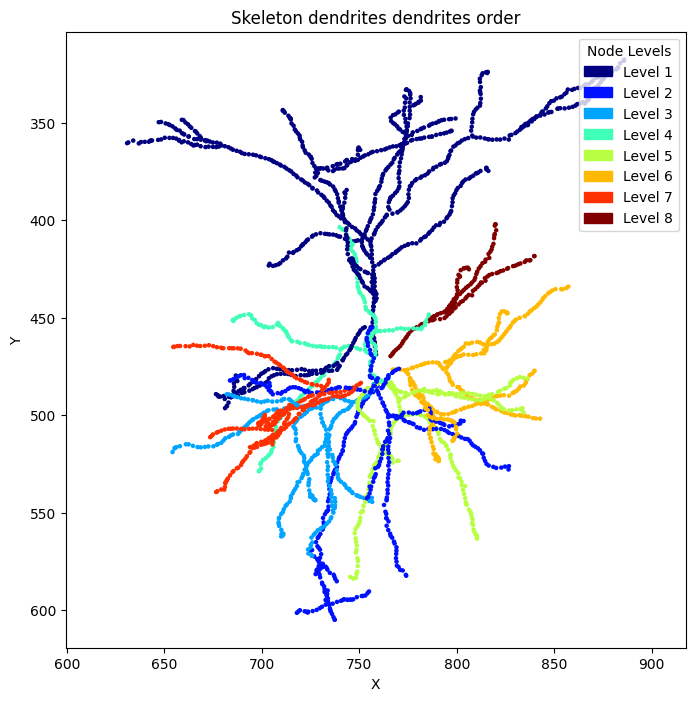

In [52]:
skp.plot_skeleton_by_levels_2d(sk_swc_levels, "dendrites", "max", neuron_id, dir_name="NA", save=False)

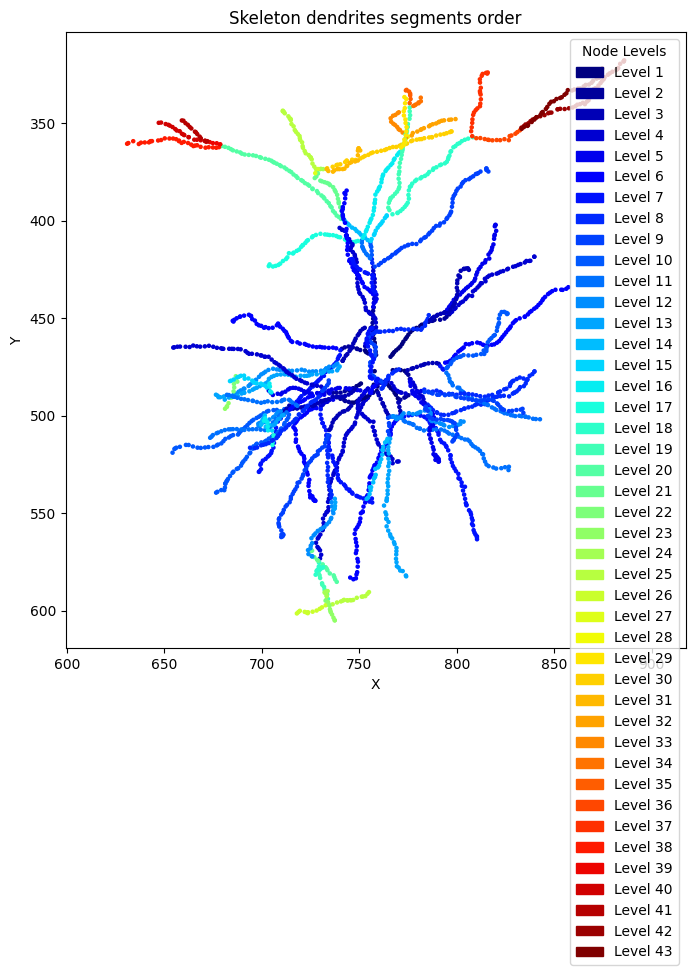

In [53]:
skp.plot_skeleton_by_levels_2d(sk_swc_levels, "segments", "max", neuron_id, dir_name="NA", save=False)

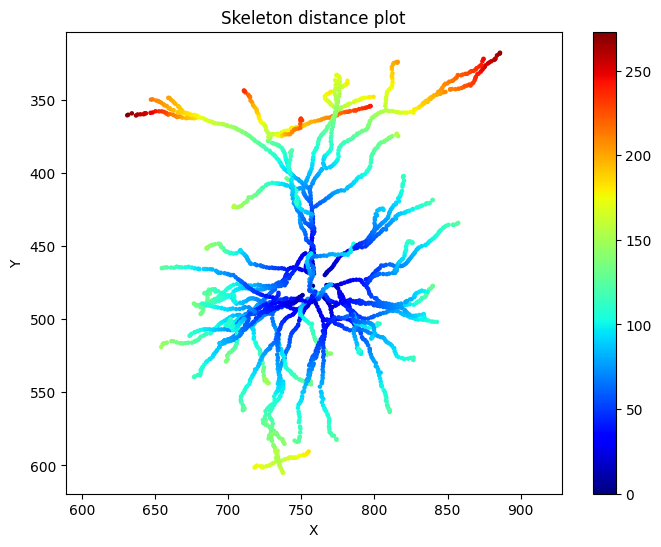

In [54]:
skp.plot_skeleton_distance_2d(sk_swc_levels, neuron_id, dir_name="NA", save=False, view="xy")

In [55]:
skp.plot_skeleton_distance_3d_interactive(sk_swc_levels, neuron_id, dir_name="NA", save=False)

### 2.4 Skeleton analysis

Here we will do a simple analysis to calculate distance distribution of a skeleton neurons

In [56]:
def plot_sholl_complexity(sk_df, bin_size=5.0, max_dist=None, ax=None):
    """
    Parameters
    ----------
    sk_df : pd.DataFrame
        Skeleton table with a 'distance_from_soma' column (in µm).
    bin_size : float
        Width of radial shells in µm.
    max_dist : float or None
        Max distance to consider. If None, uses the max distance in the data.
    ax : matplotlib.axes.Axes or None
        Existing axis to plot into. If None, creates a new figure.

    """
    # Get distances as a clean 1D numpy array
    dists = sk_df['distance_from_soma'].to_numpy()
    dists = dists[np.isfinite(dists)]  # drop NaN / inf if any

    if max_dist is None:
        max_dist = dists.max()

    # Radial shells
    bins = np.arange(0, max_dist + bin_size, bin_size)
    counts, edges = np.histogram(dists, bins=bins)

    # Bin centers for plotting
    centers = 0.5 * (edges[:-1] + edges[1:])

    # Plot
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(centers, counts, marker='o')
    ax.set_xlabel('Distance from soma (µm)')
    ax.set_ylabel('Number of skeleton nodes')
    ax.set_title('Sholl-like complexity profile')
    ax.grid(True, alpha=0.3)

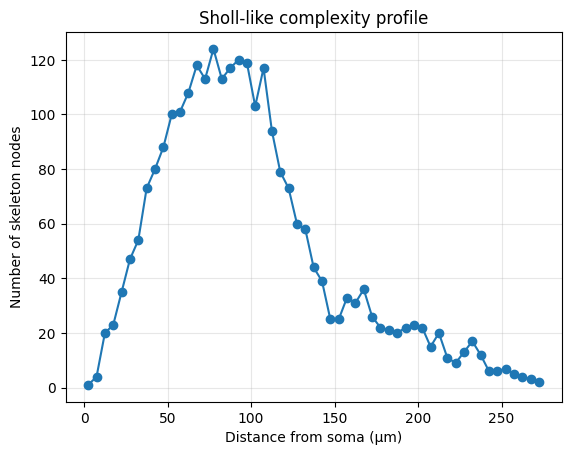

In [57]:
ax = plot_sholl_complexity(sk_swc_levels, bin_size=5)
plt.show()

# 3. Functional Profile

Here we will go through a neuron's functiona properties. \
This part includes plotting functional synapses and simple analysis

## 3.1 Plot functional synapses

In [58]:
def plot_functional_synapses(pre_synapse_df, nucleus_detection_v0, functional_properties_v3_bcm, pt_root_id, y_depth):
    """
    Plot all synapses of a postsynaptic neuron (grey) and highlight those whose
    presynaptic neurons have functional properties (colored by orientation).
    """
    # ---------- Soma & relative coordinates ----------
    # Work on a copy to avoid side effects
    pre_synapse_df = pre_synapse_df.copy()

    # Get soma position (in nm)
    mask_soma = nucleus_detection_v0['pt_root_id'] == pt_root_id
    soma_pos = convert_to_nm(nucleus_detection_v0[mask_soma].pt_position, voxel_size=[4, 4, 40])
    soma_pos_x = soma_pos[0, 0]
    soma_pos_y = soma_pos[0, 1]
    soma_pos_z = soma_pos[0, 2]

    # Absolute positions (nm)
    pre_synapse_df['ctr_pt_position_real'] = list(
        convert_to_nm(pre_synapse_df['ctr_pt_position'], voxel_size=[4, 4, 40])
    )

    # Soma-relative positions (nm)
    pre_synapse_df['ctr_pt_position_somarel'] = pre_synapse_df['ctr_pt_position_real'].apply(
        lambda pos: [pos[0] - soma_pos_x,
                     pos[1] - soma_pos_y,
                     pos[2] - soma_pos_z]
    )

    # For background scatter
    syn_pos_rel = np.array(pre_synapse_df['ctr_pt_position_somarel'].tolist())

    # ---------- Base plot: Soma and all synapses ----------
    synapse_color_bg = "#B3B3B3"  # Light gray
    
    # Get soma color
    mask = functional_properties_v3_bcm['pt_root_id'] == pt_root_id  # or neuron_id
    soma_ori = functional_properties_v3_bcm.loc[mask, 'pref_ori'].iloc[0]
    soma_ori_norm = soma_ori / np.pi  # Normalize to [0, 1] for HSV
    soma_color_rgba = cm.hsv(soma_ori_norm)
    soma_color = soma_color_rgba[:3]   # RGB only (drop alpha if you want)
    

    fig, ax = plt.subplots(figsize=(6, 6))   # <- explicit fig, ax
    ax.scatter(syn_pos_rel[:, 0] / 1000,
               syn_pos_rel[:, 1] / 1000,
               s=1,
               color=synapse_color_bg)
    ax.scatter(0, 0, s=50, color = soma_color, marker='^', edgecolors='k', linewidths=1)  # soma at origin

    # =============== Functional synapses ===================

    # Synapses whose presynaptic neurons have functional properties
    mask_has_func = pre_synapse_df['pre_pt_root_id'].isin(functional_properties_v3_bcm['pt_root_id'])
    list_pre_pt_root_id = pre_synapse_df[mask_has_func]['pre_pt_root_id'].values

    # Postsynaptic orientation (once)
    post_ori = functional_properties_v3_bcm['pref_ori'][
        functional_properties_v3_bcm['pt_root_id'] == pt_root_id
    ].iloc[0]

    # Plot all presynaptic neurons' synapses (colored by Δorientation)
    for pt_pre_id in list_pre_pt_root_id:
        # Synapse locations relative to soma (nm)
        mask_syn = pre_synapse_df['pre_pt_root_id'] == pt_pre_id
        syn_pos_nm_rel = np.array(pre_synapse_df[mask_syn].ctr_pt_position_somarel.tolist())

        # Preferred orientation of this presynaptic neuron
        mask_func = functional_properties_v3_bcm['pt_root_id'] == pt_pre_id
        pref_ori = functional_properties_v3_bcm['pref_ori'][mask_func].iloc[0]

        # Color from orientation difference
        synapse_color = orientation_to_colour(pref_ori, post_ori)

        # Plot colored synapses (µm)
        ax.scatter(syn_pos_nm_rel[:, 0] / 1000,
                   syn_pos_nm_rel[:, 1] / 1000,
                   s=5,
                   color=synapse_color)

    ax.set_aspect('equal')

    ax.set_title(f"Functional synapses: {len(list_pre_pt_root_id)}/{len(pre_synapse_df)}")
    ax.set_xlabel('x (μm)')
    ax.set_ylabel('y (μm)')

    # Symmetric window around soma in y, flipped so deeper is down
    ax.set_xlim(-200, 200)
    ax.set_ylim(y_depth, -y_depth)

    # ---------- Colorbar: Δ orientation (deg) ----------
    # relative_orientation in orientation_to_colour is in [0,1] and corresponds to [0,180°]
    norm = plt.Normalize(0, 1)
    sm = cm.ScalarMappable(norm=norm, cmap=cm.hsv)
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=ax)
    tick_vals = np.linspace(0, 1, 7)
    cbar.set_ticks(tick_vals)
    cbar.set_ticklabels((tick_vals * 180).astype(int))
    cbar.set_label('Δ orientation (deg)')

    plt.show()


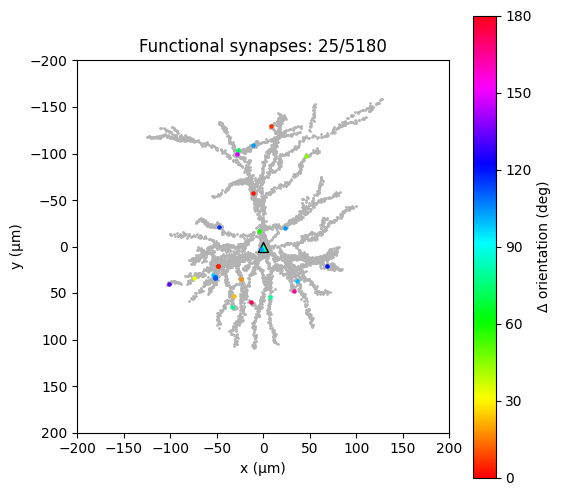

In [59]:
plot_functional_synapses(pre_synapse_df, nucleus_detection_v0, functional_properties_v3_bcm, neuron_id, 200)

### 3.2 Plot relative orientation difference

In [60]:
def wrap_to_half_pi(delta_rad):
    """
    Wrap angle to [-pi/2, +pi/2]
    """
    return (delta_rad + np.pi/2) % np.pi - np.pi/2


def plot_relative_ori_hist(pre_synapse_df, functional_properties_v3_bcm, pt_root_id,
                           bins=18, degrees=True):
    """
    Plot histogram of relative orientation (post-pre) for all synapses
    of a given postsynaptic neuron whose presynaptic partners have
    functional properties.
    
    degrees : bool
        If True, plot x-axis in degrees [-90, 90].
        If False, plot in radians [-pi/2, pi/2].
    """

    # --- postsynaptic orientation ---
    mask_post = functional_properties_v3_bcm['pt_root_id'] == pt_root_id
    if not mask_post.any():
        raise ValueError(f"Post neuron {pt_root_id} not found in functional_properties_v3_bcm.")
    post_ori = functional_properties_v3_bcm.loc[mask_post, 'pref_ori'].iloc[0]  # radians

    # --- attach presynaptic orientations to each synapse ---
    func_pre = functional_properties_v3_bcm[['pt_root_id', 'pref_ori']].rename(
        columns={'pt_root_id': 'pre_pt_root_id', 'pref_ori': 'pref_ori_pre'}
    )

    # inner merge: keep only synapses whose pre neuron has functional data
    syn_with_func = pre_synapse_df.merge(func_pre, on='pre_pt_root_id', how='inner')

    if syn_with_func.empty:
        raise ValueError("No functional presynaptic partners found for this neuron.")

    # --- compute relative orientation (pre - post), wrapped to [-pi/2, pi/2] ---
    delta_raw = post_ori - syn_with_func['pref_ori_pre'].to_numpy()
    delta_wrapped = wrap_to_half_pi(delta_raw)  # radians in [-pi/2, +pi/2]

    if degrees:
        delta_plot = np.rad2deg(delta_wrapped)
        x_label = "Δ orientation (post - pre) [deg]"
        bin_edges = np.linspace(-90, 90, bins + 1)
    else:
        delta_plot = delta_wrapped
        x_label = "Δ orientation (post - pre) [rad]"
        bin_edges = np.linspace(-np.pi/2, np.pi/2, bins + 1)

    # --- plot histogram ---
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.hist(delta_plot, bins=bin_edges, edgecolor='black', linewidth=0.5)

    ax.axvline(0, color='k', linestyle='--', linewidth=1)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Synapse count")
    ax.set_title(
        f"Δ orientation\n"
        f"{len(syn_with_func)}/{len(pre_synapse_df)} functional presynapse"
    )
    plt.tight_layout()
    plt.show()

    return syn_with_func, delta_wrapped  # in case you want to reuse the numbers later


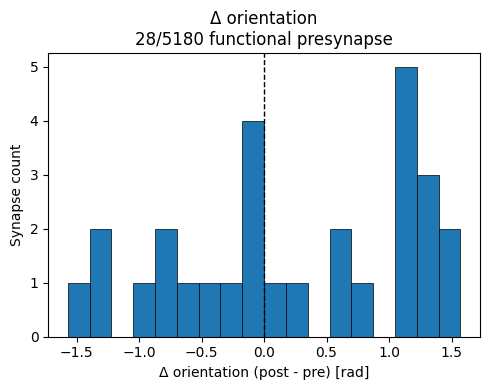

In [61]:
syn_func_df, delta_rad = plot_relative_ori_hist(pre_synapse_df, functional_properties_v3_bcm, pt_root_id=neuron_id, bins=18, degrees=False)

### 3.3 Simple connectivity summary: Input cell type

In [63]:
# 1) Keep only valid rows in the cell-type table (optional but good practice)
celltypes = aibs_metamodel_celltypes_v661.copy()
celltypes = celltypes[celltypes['valid']]
celltypes = celltypes[['pt_root_id', 'cell_type']]

# 2) Merge presynaptic cell_type onto each synapse row
pre_with_ct = pre_synapse_df.merge(
    celltypes,
    left_on='pre_pt_root_id',
    right_on='pt_root_id',
    how='left',   # keep all synapses, even if no cell_type annotation
)

# 3) Simple connectivity summaries
# 3a) Count synapses per presynaptic cell_type
synapses_per_type = (
    pre_with_ct
    .groupby('cell_type', dropna=False)
    .size()
    .reset_index(name='n_synapses')
    .sort_values('n_synapses', ascending=False)
)

print("Synapse counts by presynaptic cell_type:")
print(synapses_per_type)

# 3b) Also count *unique presynaptic neurons* per cell_type (optional)
inputs_per_type = (
    pre_with_ct
    .groupby('cell_type', dropna=False)
    .agg(
        n_synapses=('pre_pt_root_id', 'size'),
        n_presyn_neurons=('pre_pt_root_id', 'nunique')
    )
    .sort_values('n_synapses', ascending=False)
)

print("\nConnectivity summary by presynaptic cell_type:")
print(inputs_per_type)

Synapse counts by presynaptic cell_type:
    cell_type  n_synapses
15       <NA>        4740
14   pericyte         653
6          BC         196
8          MC         106
0         23P          67
13      oligo          29
1          4P          21
11  astrocyte          19
12  microglia          15
2       5P-ET          11
3       5P-IT           8
5       6P-IT           7
9         NGC           6
10        OPC           5
7         BPC           3
4       6P-CT           1

Connectivity summary by presynaptic cell_type:
           n_synapses  n_presyn_neurons
cell_type                              
<NA>             4740              4286
pericyte          653                 3
BC                196                76
MC                106                47
23P                67                55
oligo              29                 8
4P                 21                18
astrocyte          19                12
microglia          15                10
5P-ET              11        

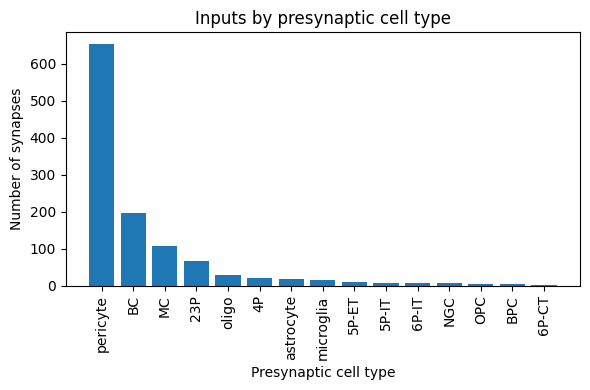

In [64]:
# Start from the summary that still includes NaNs
synapses_per_type = (
    pre_with_ct
    .groupby('cell_type', dropna=False)
    .size()
    .reset_index(name='n_synapses')
    .sort_values('n_synapses', ascending=False)
)

# For plotting: remove rows where cell_type is NaN
plot_df = synapses_per_type.dropna(subset=['cell_type'])

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(
    plot_df['cell_type'].astype(str),
    plot_df['n_synapses']
)
plt.xticks(rotation=90)
plt.ylabel('Number of synapses')
plt.xlabel('Presynaptic cell type')
plt.title('Inputs by presynaptic cell type')
plt.tight_layout()
plt.show()

### 3.4 Simple connectivity summary: Input cell type and distance to soma

In [65]:
# Get soma position (in nm)
mask_soma = nucleus_detection_v0['pt_root_id'] == neuron_id
soma_pos = convert_to_nm(nucleus_detection_v0[mask_soma].pt_position, voxel_size=[4, 4, 40])
soma_pos_x = soma_pos[0, 0]
soma_pos_y = soma_pos[0, 1]
soma_pos_z = soma_pos[0, 2]

pre_synapse_df['ctr_pt_position_real'] = list(
    convert_to_nm(pre_synapse_df['ctr_pt_position'], voxel_size=[4, 4, 40])
)

pre_synapse_df['ctr_pt_position_somarel'] = pre_synapse_df['ctr_pt_position_real'].apply(
    lambda pos: [pos[0] - soma_pos_x,
                 pos[1] - soma_pos_y,
                 pos[2] - soma_pos_z]
)

# --- cell-type lookup ---
celltypes = (
aibs_metamodel_celltypes_v661
    [aibs_metamodel_celltypes_v661['valid']]          # keep valid rows
    [['pt_root_id', 'cell_type']]
    .drop_duplicates('pt_root_id')
)

# --- attach cell_type to each synapse via pre_pt_root_id ---
pre_with_ct = pre_synapse_df.merge(
    celltypes,
    left_on='pre_pt_root_id',
    right_on='pt_root_id',
    how='left'
)

# keep only rows where we actually have soma-relative coords
mask = pre_with_ct['ctr_pt_position_somarel'].notna()

coords = np.vstack(pre_with_ct.loc[mask, 'ctr_pt_position_somarel'].to_numpy())
# coords shape: (N_synapses, 3)

r_nm = np.linalg.norm(coords, axis=1)          # distance in nm
r_um = r_nm / 1000.0                           # convert to µm

pre_with_ct.loc[mask, 'r_um'] = r_um

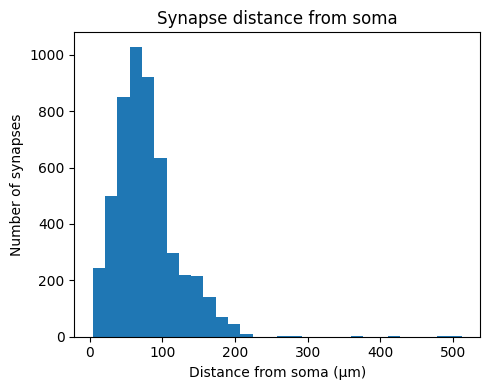

In [66]:
plt.figure(figsize=(5, 4))
plt.hist(pre_with_ct['r_um'].dropna(), bins=30)
plt.xlabel('Distance from soma (µm)')
plt.ylabel('Number of synapses')
plt.title('Synapse distance from soma')
plt.tight_layout()
plt.show()

/tmp/ipykernel_3972883/2580578385.py:19: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



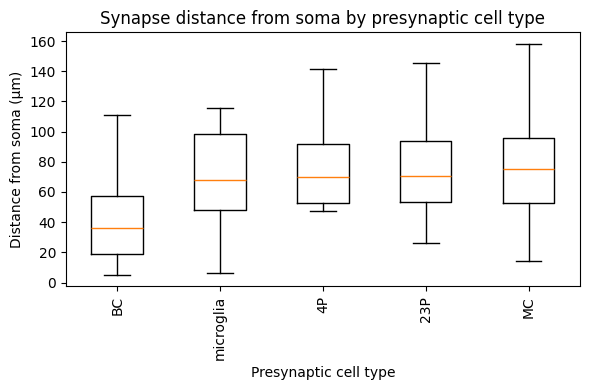

In [67]:
plot_df = pre_with_ct.dropna(subset=['cell_type', 'r_um'])

# optional: keep only cell types with >= 10 synapses
counts = plot_df['cell_type'].value_counts()
keep_types = counts[counts >= 10].index
plot_df = plot_df[plot_df['cell_type'].isin(keep_types)]

# order cell types by median distance (nice for visualization)
order = (
    plot_df.groupby('cell_type')['r_um']
    .median()
    .sort_values()
    .index
)

data = [plot_df.loc[plot_df['cell_type'] == ct, 'r_um'] for ct in order]

plt.figure(figsize=(6, 4))
plt.boxplot(data, labels=order, showfliers=False)
plt.xticks(rotation=90)
plt.ylabel('Distance from soma (µm)')
plt.xlabel('Presynaptic cell type')
plt.title('Synapse distance from soma by presynaptic cell type')
plt.tight_layout()
plt.show()
